In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from helper_funcs import *
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [26]:
zip_data = pd.read_csv('https://nycdsacapstone2021.blob.core.windows.net/additionaldata/final_zip_data.csv', index_col=0)


In [27]:
zip_data['school_rating'].fillna(value = zip_data['school_rating'].mean(), inplace = True)
zip_data['Hosp_count'].fillna(value = zip_data['Hosp_count'].mean(), inplace = True)

In [28]:
### Cluster zip codes to feed into redfin data
## For now, keeping numerical columns that have no null values 
zip_data = zip_data[zip_data['Population'] > 0]
cols_to_cluster = [ 'Population', 'IncomePerHousehold', 'AverageHouseValue']
zip_cluster = zip_data[cols_to_cluster]
scaler = MinMaxScaler()
# zip_cluster.dropna(axis = 0, inplace = True) 
zip_cluster = scaler.fit_transform(zip_cluster)

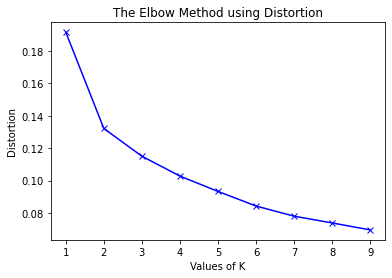

In [29]:
### Use elbow method to determine number of clusters
X = zip_cluster
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [30]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(zip_cluster)
zip_data['cluster'] = kmeans.labels_

In [50]:
grouped = zip_data.groupby('cluster')[ 'Population', 'HouseholdsPerZipCode','AverageHouseValue', 'over_65_ratio','school_rating', 'IncomePerHousehold', 'NumberOfBusinesses','Hosp_count'].mean()
grouped = grouped.reset_index()
fig = px.parallel_coordinates(grouped, color = 'cluster', 
                             dimensions = ['cluster','Population', 'AverageHouseValue', 'IncomePerHousehold', 'over_65_ratio'])
fig.show()

In [49]:
for_merge = zip_data[['cluster', 'Population', 'HouseholdsPerZipCode','AverageHouseValue', 'school_rating', 'IncomePerHousehold', 'NumberOfBusinesses','Hosp_count', 'over_65_ratio']]
for_merge = for_merge.reset_index()
for_merge

,ZipCode,cluster,Population,HouseholdsPerZipCode,AverageHouseValue,school_rating,IncomePerHousehold,NumberOfBusinesses,Hosp_count,over_65_ratio
0,20001,0,38551,16500,692900,5.727273,116195,1978,1.008264,0.078726
1,20002,0,52370,22973,637300,4.851852,90424,1674,1.008264,0.085151
2,20003,2,26454,11724,806500,5.416667,134438,1227,1.008264,0.101423
3,20004,2,1622,1127,594600,8.000000,146822,961,1.008264,0.117005
4,20005,2,12775,8316,536700,6.000000,93956,2366,1.008264,0.090953
...,...,...,...,...,...,...,...,...,...,...
5031,39870,1,2238,886,91200,3.000000,27203,25,1.008264,0.190947
5032,39877,1,500,197,68700,5.279213,32750,8,1.008264,0.451039
5033,39885,1,76,37,125000,5.279213,39167,7,1.008264,0.321429
5034,39886,1,1616,675,66900,3.000000,36602,31,1.008264,0.195031


In [40]:
df = get_all()

----pulling Redfin data from Azure storage----
----Done----
----pulling schools data from Azure storage----
----Done----
----merging all data----
----Done----
Shape: (75360, 22)


In [41]:
df = pd.merge(df, for_merge, how = 'left', left_on = 'zip', right_on = 'ZipCode')

In [42]:
df

,Sale_Type,Sold_Date,Prop_Type,ADDRESS,CITY,State,PRICE,BEDS,BATHS,LOCATION,...,ZipCode,cluster,Population,HouseholdsPerZipCode,AverageHouseValue,school_rating,IncomePerHousehold,NumberOfBusinesses,Hosp_count_y,over_65_ratio
0,MLS Listing,NaN,Condo/Co-op,810 O St NW #201,Washington,DC,899900.0,2.0,2.0,OLD CITY II,...,20001.0,0.0,38551.0,16500.0,692900.0,5.727273,116195.0,1978.0,1.008264,0.078726
1,MLS Listing,NaN,Townhouse,29 Q St NW,Washington,DC,1175000.0,4.0,3.5,OLD CITY II,...,20001.0,0.0,38551.0,16500.0,692900.0,5.727273,116195.0,1978.0,1.008264,0.078726
2,MLS Listing,NaN,Condo/Co-op,815 T St NW Unit A,Washington,DC,825000.0,3.0,2.5,OLD CITY II,...,20001.0,0.0,38551.0,16500.0,692900.0,5.727273,116195.0,1978.0,1.008264,0.078726
3,MLS Listing,NaN,Townhouse,2213 2nd St NW,Washington,DC,835427.0,4.0,2.0,LEDROIT PARK,...,20001.0,0.0,38551.0,16500.0,692900.0,5.727273,116195.0,1978.0,1.008264,0.078726
4,MLS Listing,NaN,Condo/Co-op,2914 11th St NW #103,Washington,DC,650000.0,2.0,2.0,COLUMBIA HEIGHTS,...,20001.0,0.0,38551.0,16500.0,692900.0,5.727273,116195.0,1978.0,1.008264,0.078726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75355,MLS Listing,NaN,Multi-Family (2-4 Unit),3042 SE Clayton St,Stuart,FL,460000.0,6.0,3.0,Golden Gate,...,34997.0,0.0,40405.0,17423.0,253500.0,5.571429,58789.0,1286.0,1.008264,0.299292
75356,MLS Listing,NaN,Single Family Residential,7430 SW Harbor Cove Dr,Stuart,FL,459900.0,3.0,2.0,Tidewater Point,...,34997.0,0.0,40405.0,17423.0,253500.0,5.571429,58789.0,1286.0,1.008264,0.299292
75357,MLS Listing,NaN,Single Family Residential,886 SW Blue Stem Way,Stuart,FL,895000.0,4.0,3.5,FLORIDA CLUB PUD PHASE IB,...,34997.0,0.0,40405.0,17423.0,253500.0,5.571429,58789.0,1286.0,1.008264,0.299292
75358,MLS Listing,NaN,Single Family Residential,6998 SE Sleepy Hollow Ln,Stuart,FL,659900.0,4.0,3.0,Summerfield Golf Club Ph,...,34997.0,0.0,40405.0,17423.0,253500.0,5.571429,58789.0,1286.0,1.008264,0.299292


In [51]:
by_cluster = df.groupby('cluster').mean()
by_cluster = by_cluster[[ 'PRICE', 'BEDS', 'BATHS', 'SF', 'Lot_Size', 'YearBuilt',
       'px_perSF', 'overallRating',  'Population', 'HouseholdsPerZipCode','AverageHouseValue', 'school_rating', 'IncomePerHousehold', 'NumberOfBusinesses',  'over_65_ratio']]

In [52]:
by_cluster

,PRICE,BEDS,BATHS,SF,Lot_Size,YearBuilt,px_perSF,overallRating,Population,HouseholdsPerZipCode,AverageHouseValue,school_rating,IncomePerHousehold,NumberOfBusinesses,over_65_ratio
cluster,,,,,,,,,,,,,,,
0.0,5.609476e+05,3.174766,4.207569,1957.963939,46597.235442,1984.634307,281.325227,5.441905,43394.237091,16904.867058,269539.678927,5.441905,66290.585360,1208.665868,0.161531
1.0,5.648332e+05,3.319529,2.443381,2148.136013,238937.652479,1990.702634,255.315942,5.195151,6767.061536,2701.004543,173361.026982,5.217764,50484.766382,180.577368,0.220815
2.0,1.286756e+06,3.120649,2.830516,2431.616762,193210.627146,1990.501154,517.211920,7.216812,15074.763198,6470.938971,539145.166443,6.832909,104859.517233,818.392989,0.218813
3.0,5.685773e+05,3.229420,2.832294,2037.250884,244995.421754,1989.501912,269.333312,5.349048,22321.133552,9130.443410,220567.376002,5.346756,58786.955883,700.545788,0.209994


In [53]:
by_cluster = by_cluster.reset_index()
by_cluster.rename(
    columns = {
        "PRICE": "avg_cluster_price",
        "BEDS":"avg_cluster_beds",
        "BATHS":"avg_cluster_baths",
        "SF":"avg_cluster_sf",
        "Lot_Size":"avg_cluster_lot_size",
        "YearBuilt": "avg_cluster_year",
        "px_perSF": "avg_cluster_price_persf",
        "overallRating": "avg_cluster_school_rating",
        "Hops_count":"avg_cluster_hosp_count"
    }, inplace = True
)

In [54]:
by_cluster

,cluster,avg_cluster_price,avg_cluster_beds,avg_cluster_baths,avg_cluster_sf,avg_cluster_lot_size,avg_cluster_year,avg_cluster_price_persf,avg_cluster_school_rating,Population,HouseholdsPerZipCode,AverageHouseValue,school_rating,IncomePerHousehold,NumberOfBusinesses,over_65_ratio
0,0.0,5.609476e+05,3.174766,4.207569,1957.963939,46597.235442,1984.634307,281.325227,5.441905,43394.237091,16904.867058,269539.678927,5.441905,66290.585360,1208.665868,0.161531
1,1.0,5.648332e+05,3.319529,2.443381,2148.136013,238937.652479,1990.702634,255.315942,5.195151,6767.061536,2701.004543,173361.026982,5.217764,50484.766382,180.577368,0.220815
2,2.0,1.286756e+06,3.120649,2.830516,2431.616762,193210.627146,1990.501154,517.211920,7.216812,15074.763198,6470.938971,539145.166443,6.832909,104859.517233,818.392989,0.218813
3,3.0,5.685773e+05,3.229420,2.832294,2037.250884,244995.421754,1989.501912,269.333312,5.349048,22321.133552,9130.443410,220567.376002,5.346756,58786.955883,700.545788,0.209994


In [55]:
final = df.copy()
final = final[['zip', 'cluster']]
final.drop_duplicates(subset=['zip'], inplace = True)
final = pd.merge(final, by_cluster, how = 'left', left_on = 'cluster', right_on = 'cluster')

In [56]:
final.drop(columns = ['index'], axis=1, inplace = True)


KeyError: "['index'] not found in axis"

In [57]:
final.rename(columns = {'zip':'ZipCode'}, inplace = True)

In [58]:
final = final.set_index("ZipCode")

In [61]:
final

,cluster,avg_cluster_price,avg_cluster_beds,avg_cluster_baths,avg_cluster_sf,avg_cluster_lot_size,avg_cluster_year,avg_cluster_price_persf,avg_cluster_school_rating,Population,HouseholdsPerZipCode,AverageHouseValue,school_rating,IncomePerHousehold,NumberOfBusinesses,over_65_ratio
ZipCode,,,,,,,,,,,,,,,,
20001,0.0,5.609476e+05,3.174766,4.207569,1957.963939,46597.235442,1984.634307,281.325227,5.441905,43394.237091,16904.867058,269539.678927,5.441905,66290.585360,1208.665868,0.161531
20002,0.0,5.609476e+05,3.174766,4.207569,1957.963939,46597.235442,1984.634307,281.325227,5.441905,43394.237091,16904.867058,269539.678927,5.441905,66290.585360,1208.665868,0.161531
20003,2.0,1.286756e+06,3.120649,2.830516,2431.616762,193210.627146,1990.501154,517.211920,7.216812,15074.763198,6470.938971,539145.166443,6.832909,104859.517233,818.392989,0.218813
20004,2.0,1.286756e+06,3.120649,2.830516,2431.616762,193210.627146,1990.501154,517.211920,7.216812,15074.763198,6470.938971,539145.166443,6.832909,104859.517233,818.392989,0.218813
20005,2.0,1.286756e+06,3.120649,2.830516,2431.616762,193210.627146,1990.501154,517.211920,7.216812,15074.763198,6470.938971,539145.166443,6.832909,104859.517233,818.392989,0.218813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34987,1.0,5.648332e+05,3.319529,2.443381,2148.136013,238937.652479,1990.702634,255.315942,5.195151,6767.061536,2701.004543,173361.026982,5.217764,50484.766382,180.577368,0.220815
34990,3.0,5.685773e+05,3.229420,2.832294,2037.250884,244995.421754,1989.501912,269.333312,5.349048,22321.133552,9130.443410,220567.376002,5.346756,58786.955883,700.545788,0.209994
34994,3.0,5.685773e+05,3.229420,2.832294,2037.250884,244995.421754,1989.501912,269.333312,5.349048,22321.133552,9130.443410,220567.376002,5.346756,58786.955883,700.545788,0.209994


In [60]:
final.to_csv('clusters.csv')